### Classifying benign vs malignant tumors: We would like to classify if a tumor is benign or malign based on its attributes. We use data from the Breast Cancer Wisconsin Data Set of the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original).

### The input file is named “hw2 question3.csv” for our experiments. The rows of these files refer to the data samples, while the columns denote the features (columns 1-9) and the outcome variable (column 10), as described bellow:

### 1. Clump Thickness: discrete values {1, 10}
### 2. Uniformity of Cell Size: discrete values {1, 10}
### 3. Uniformity of Cell Shape: discrete values {1, 10} 
### 4. Marginal Adhesion: discrete values {1, 10}
### 5. Single Epithelial Cell Size: discrete values {1, 10} 
### 6. Bare Nuclei: discrete values {1, 10}
### 7. Bland Chromatin: discrete values {1, 10}
### 8. Normal Nucleoli: discrete values {1, 10}
### 9. Mitoses: discrete values {1, 10}
### 10. Class: 2 for benign, 4 for malignant (this is the outcome variable)

### (a) Compute the number of samples belonging to the benign and the number of samples belonging to the malignant case. What do you observe? Are the two classes equally represented in the data? Separate the data into a train (2/3 of the data) and a test (1/3 of the data) set. Make sure that both classes are represented with the same proportion in both sets.

By observing the dataset, we can see that there are 444 benign tumors data in the dataset, and 239 malignant tumors data in the dataset. In this case, the two classes are not equally represented in the data.
Here, I leverage sklearn.model_selection.train_test_split to split the dataset. In order to make both classes represented with the same proportion in both sets, I set the attribute stratify = y, where y is the tumor classes.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

tumor_features=['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size',
                        'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'tumors']
headers = tumor_features
df = pd.read_csv('./dataset/hw2_question3.csv', names=headers)

In [2]:
count_benign = 0
for e in df['tumors']:
    if(e == 2):
        count_benign += 1

In [3]:
print("#number of benign tumors: ", count_benign)
print("#number of malignant tumors: ", len(df)-count_benign)

#number of benign tumors:  444
#number of malignant tumors:  239


In [4]:
X = df[['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size',
               'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses']]
y = df['tumors']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10, stratify = y)

### (b) Implement two decision trees using the training samples. The splitting criterion for the first one should be the entropy, while for the second one should be the gini index. Plot the 10-fold stratified cross validated accuracy on the train and test data while the maximum depth in the tree increases for both splitting criteria. Do you observe any differences in practice?

In this part, I do stratified cross validation on the dataset using DecisionTreeClassifier. The input max_depth of the classifiers are from 1 to 50.

By observing the plot, we can discover that the accuracy curve goes flat after about tree_depth = 9, that means tree depth over 9 is meaningless. Moreover, we can see that the optimal accuracies of the classifiers with "Gini" and "Entropy" are around tree_depth= 4~7. That indicates that the tree depth of the classifiers should not be too large.

In [5]:
from sklearn import tree
from sklearn.model_selection import StratifiedKFold
from statistics import mean
class DecisionTreeClassifier:
    def __init__(self, criterion, max_depth):
        self.clf = tree.DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, random_state = 87)
        self.numFolds = 10
    def fit(self, X, y):
        self.clf.fit(X, y)
    def predict(self, X):
        return self.clf.predict(X)
    def score(self, X, y):
        return self.clf.score(X, y)
    def cross_validation(self, X, y):
        kf = StratifiedKFold(n_splits= self.numFolds, random_state = 87)
        fold = 0
        ret = []
        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            self.fit( X_train, y_train)
            
            score = self.score(X_test, y_test)
            ret.append(score)
            fold += 1
        #print("Average Auc Score:", mean(ret))
        return mean(ret)

In [6]:
entro = []
entro_test = []
gini = []
gini_test = []

for i in range(1,50):
    dtc = DecisionTreeClassifier( criterion="entropy", max_depth=i)
    entro.append(dtc.cross_validation(X_train.values, y_train.values.ravel()))
    entro_test.append( dtc.score(X_test.values, y_test.values.ravel()))
    dtc = DecisionTreeClassifier( criterion="gini", max_depth=i)
    gini.append(dtc.cross_validation(X_train.values, y_train.values.ravel()))
    gini_test.append(dtc.score(X_test.values, y_test.values.ravel()))

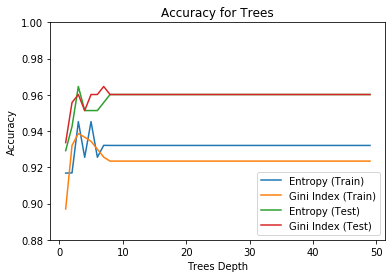

In [8]:
import matplotlib.pyplot as plt

max_depth_range = list(range(1, 50))


plt.plot(max_depth_range, entro, label="Entropy (Train)")
plt.plot(max_depth_range, gini, label="Gini Index (Train)")

plt.plot(max_depth_range, entro_test, label="Entropy (Test)")
plt.plot(max_depth_range, gini_test, label="Gini Index (Test)")

plt.ylim(ymin = 0.88)
plt.ylim(ymax = 1.0)
plt.title('Accuracy for Trees')
plt.xlabel('Trees Depth')
plt.ylabel('Accuracy')
plt.legend(loc="lower right", prop={'size': 10})
plt.show()

### (c) Feature Importance 
### Run a 10-fold stratified cross-validation for modeling this problem with a random forest model. You can choose to do a secondary 10-fold cross-validation on the training set in each fold to find the optimal number of trees and depth of each tree if you choose. Is this model more accurate (averaged over all 10 folds) than the decision trees?. As ranked by the feature importance, please provide a ranking of the features as their average position (standard deviation) of the rank order. Is this ranking it by Gini, Mean Decrease in Accuracy, or something else? What should the final model’s list of features be? Please justify your answer.

The accuracy obtained by RamdomForestClassifier, in this case, is about 97%~98% in accuracy. The accuracy here is obviously higher than decision trees. And we can see from the feature importances, the rank of the features is 'Uniformity of Cell Shape', 'Uniformity of Cell Size', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Clump Thickness', 'Marginal Adhesion', 'Mitoses'.

In scikit-learn, it implement the importance using "gini importance" or "mean decrease impurity" and is defined as the total decrease in node impurity (weighted by the probability of reaching that node (which is approximated by the proportion of samples reaching that node)) averaged over all trees of the ensemble.

In [9]:
from sklearn import ensemble

class RandomForestClassifier:
    def __init__(self, n_trees, criterion, max_depth):
        self.clf = ensemble.RandomForestClassifier( n_estimators = n_trees, criterion = criterion, max_depth = max_depth, random_state = 87)
        self.numFolds = 10
    def fit(self, X, y):
        self.clf.fit(X, y)
    def predict(self, X):
        return self.clf.predict(X)
    def score(self, X, y):
        return self.clf.score(X, y)
    def cross_validation(self, X, y):
        kf = StratifiedKFold(n_splits= self.numFolds, random_state = 87)
        fold = 0
        ret = []
        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            self.fit( X_train, y_train)
            
            score = self.score(X_test, y_test)
            ret.append(score)
            fold += 1
        #print("Average Auc Score:", mean(ret))
        return mean(ret)
        

In [10]:
def findBestParams( md, ne, ctiterion, X, y):
    max_depth = 0
    n_esti = 0
    max_acc = 0
    for depth in md:
        for num in ne:
            rfc = RandomForestClassifier( n_trees = num, criterion=ctiterion, max_depth=depth)
            acc = rfc.cross_validation(X, y)
            if acc > max_acc:
                max_depth = depth
                n_esti = num
                max_acc = acc
    return [ max_depth, n_esti]

In [11]:
md = list(range(1, 11))  
ne = [25, 50, 75, 100, 125, 150]

findBestParams( md, ne, "entropy", X_train.values, y_train.values.ravel())

[9, 50]

In [12]:
rfc = RandomForestClassifier( n_trees = 50, criterion="entropy", max_depth=9)
rfc.fit(X_train.values, y_train.values.ravel())
rfc.score( X_test.values, y_test.values.ravel())

0.9734513274336283

Text(0.5, 0, 'Features')

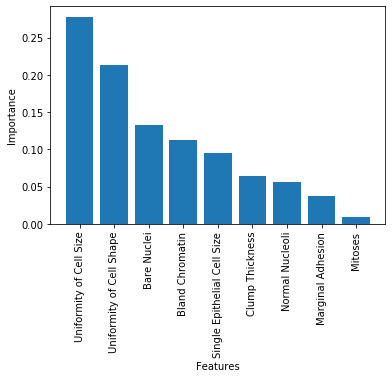

In [13]:
importances_index_desc = np.argsort(rfc.clf.feature_importances_)[::-1]
feature_labels = [tumor_features[i] for i in importances_index_desc]
# plot
plt.figure()
plt.bar(feature_labels, rfc.clf.feature_importances_[importances_index_desc])
plt.xticks(feature_labels, rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Features')

In [14]:
md = list(range(1, 11))  
ne = [25, 50, 75, 100, 125, 150]

findBestParams( md, ne, "gini", X_train.values, y_train.values.ravel())

[3, 75]

In [15]:
rfc = RandomForestClassifier( n_trees = 75, criterion="gini", max_depth=3)
rfc.fit(X_train.values, y_train.values.ravel())
rfc.score( X_test.values, y_test.values.ravel())

0.9601769911504425

Text(0.5, 0, 'Features')

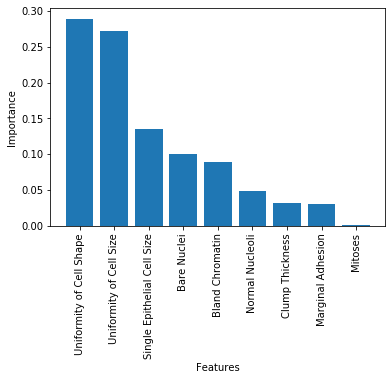

In [16]:
importances_index_desc = np.argsort(rfc.clf.feature_importances_)[::-1]
feature_labels = [tumor_features[i] for i in importances_index_desc]
# plot
plt.figure()
plt.bar(feature_labels, rfc.clf.feature_importances_[importances_index_desc])
plt.xticks(feature_labels, rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Features')